## AIM: Train Graph Convulation Networks (GCNs) as multiclass classification models for predicting the psychiatric diagnosis based on EEG features

GraphLambda with & without edge attributes for predicting psychiatric diagnosis with statistical features of the power per frequency band per channel group (frontal, central, parietal, occipital) and connectivity features per frequency band per channel group (l/m/r; frontal, central, ). Statistical features are calculated with EC data, EO data and a with the ratio between EC divided by EO.

Have to use features before feature selection, to maintain even dimensions for each graph.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import optuna

import lightning.pytorch as pl
import torch
import torch_geometric
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d
from torch_geometric.nn import  GCNConv, global_add_pool,GATConv,GINConv, GATv2Conv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx, to_networkx
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_rank
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_timeline

### Load data & features

In [2]:
import pickle
def load_file(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

In [3]:
# import IDs from selected features, to obtain subsampled sample
df_stat_conn_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_stat_conn_features.pkl')
df_stat_conn_features = df_stat_conn_features.dropna(subset=['diagnosis'])

# label encode diagnosis
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_stat_conn_features['diagnosis'])
df_stat_conn_features['diagnosis'] = le.transform(df_stat_conn_features['diagnosis'])

print(df_stat_conn_features.shape)
df_stat_conn_features.sample(3)

(2700, 843)


,ID,diagnosis,epoch,EO_frontal_delta_std,EO_frontal_delta_mean,EO_frontal_delta_median,EO_frontal_delta_skew,EO_frontal_delta_kurt,EO_central_delta_std,EO_central_delta_mean,...,ratio_gamma_m_central-r_central,ratio_gamma_m_central-l_posterior,ratio_gamma_m_central-m_posterior,ratio_gamma_m_central-r_posterior,ratio_gamma_r_central-l_posterior,ratio_gamma_r_central-m_posterior,ratio_gamma_r_central-r_posterior,ratio_gamma_l_posterior-m_posterior,ratio_gamma_l_posterior-r_posterior,ratio_gamma_m_posterior-r_posterior
2277,sub-88065153,3,10,0.354214,-0.125299,-0.117713,-0.598618,0.612918,0.362703,-0.131537,...,1.005279,1.032382,1.017060,0.993384,1.012620,1.011715,1.000180,0.998071,0.984649,0.995921
719,sub-87976817,1,12,0.407916,-0.201817,-0.197960,0.126734,0.366765,0.414978,-0.202235,...,1.088274,1.145017,1.104607,1.103005,1.207214,1.174744,1.154933,1.082253,1.131049,1.093961
887,sub-88002789,2,12,0.349919,-0.137420,-0.134001,-0.242475,0.791963,0.369361,-0.148626,...,1.071926,1.096953,1.091026,1.083454,1.119235,1.088725,1.072984,1.070642,1.080400,1.059650


In [4]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_stat_conn_features_ec = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EO') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_eo = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_ratio = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('EO'))]]
print(df_stat_conn_features_ratio.shape)
print(df_stat_conn_features_ec.shape)
print(df_stat_conn_features_eo.shape)

(2700, 283)
(2700, 283)
(2700, 283)


In [5]:
# obtain participant IDs
df_participants = df_stat_conn_features[df_stat_conn_features['epoch'] == 1]
subject_ids = df_participants['ID'].tolist()
print(subject_ids)
print(len(subject_ids))

['sub-87964717', 'sub-87965301', 'sub-87966337', 'sub-87966473', 'sub-87966517', 'sub-87966789', 'sub-87967057', 'sub-87967061', 'sub-87967325', 'sub-87967417', 'sub-87967509', 'sub-87967729', 'sub-87967773', 'sub-87967781', 'sub-87967869', 'sub-87967957', 'sub-87968045', 'sub-87968229', 'sub-87968405', 'sub-87968449', 'sub-87968541', 'sub-87968677', 'sub-87968765', 'sub-87968901', 'sub-87968945', 'sub-87969125', 'sub-87969349', 'sub-87969529', 'sub-87969573', 'sub-87969665', 'sub-87969805', 'sub-87969849', 'sub-87969937', 'sub-87969985', 'sub-87970297', 'sub-87970345', 'sub-87970389', 'sub-87970705', 'sub-87970881', 'sub-87970969', 'sub-87971021', 'sub-87971109', 'sub-87971197', 'sub-87971241', 'sub-87971373', 'sub-87974617', 'sub-87974621', 'sub-87974665', 'sub-87974709', 'sub-87974841', 'sub-87974973', 'sub-87976193', 'sub-87976369', 'sub-87976413', 'sub-87976457', 'sub-87976461', 'sub-87976505', 'sub-87976641', 'sub-87976773', 'sub-87976817', 'sub-87976953', 'sub-87977045', 'sub-87

In [6]:
# obtain synchrony features for each participant and store in list
from joblib import Parallel, delayed # for parallel processing
import os


def process_file(file):
    if '.pkl' in file: # filter pickle files
        filepath = os.path.join(subdir, file) # path to eeg file

        # load file
        feature = load_file(filepath)
        ID = file.split('_')[1]
        if 'EC' in file:
            subject_bands_syncro_matrix = np.zeros((12, 5, 9, 9))
            for i, band in enumerate(feature['syncros_eeg']):
                for epoch, matrix in enumerate(feature['syncros_eeg'][band]):
                    subject_bands_syncro_matrix[epoch, i] = matrix
            return ('EC_syncro', subject_bands_syncro_matrix, ID)

        if 'EO' in file:
            subject_bands_syncro_matrix = np.zeros((12, 5, 9, 9))
            for i, band in enumerate(feature['syncros_eeg']):
                for epoch, matrix in enumerate(feature['syncros_eeg'][band]):
                    subject_bands_syncro_matrix[epoch, i] = matrix
            return ('EO_syncro', subject_bands_syncro_matrix, ID)
        
feature_dir = r"D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\connectivity_features"

sample_ids = subject_ids # list of participants to include
count = 0
total_files = 0
for _, dirs, files in os.walk(feature_dir):
    total_files += len([file for file in files if '.pkl' in file and 'EC' in file and any(sample_id in file for sample_id in sample_ids)]) # filter participants to include])

subjects_ec_syncro_matrices = []
subjects_eo_syncro_matrices = []
subjects_ec_ids = []
subjects_eo_ids = []

for subdir, dirs, files in os.walk(feature_dir): # iterate through all files
    results = Parallel(n_jobs=-1)(delayed(process_file)(file) for file in files if any(sample_id in file for sample_id in sample_ids)) # filter participants to include)
    for result in results:
        if result is not None:
            if result[0] == 'EC_syncro':
                subjects_ec_syncro_matrices.append(result[1])
                subjects_ec_ids.append(result[2])
            elif result[0] == 'EO_syncro':
                subjects_eo_syncro_matrices.append(result[1])
                subjects_eo_ids.append(result[2])

    print(f'\rProgress: {count}/{total_files} files processed.', end = '')
    count += 1

Progress: 661/223 files processed.

In [7]:
synchrony_feature_dict = {'EC_syncro' : subjects_ec_syncro_matrices, 'EO_syncro' : subjects_eo_syncro_matrices, 'EC_IDs' : subjects_ec_ids, 'EO_IDs' : subjects_eo_ids}
with open(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\synchrony_feature_dict.pkl', 'wb') as handle:
    pickle.dump(synchrony_feature_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
synchrony_feature_dict = load_file(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\synchrony_feature_dict.pkl')
subjects_ec_syncro_matrices = synchrony_feature_dict['EC_syncro']
subjects_eo_syncro_matrices = synchrony_feature_dict['EO_syncro']
subjects_ec_ids = synchrony_feature_dict['EC_IDs']
subjects_eo_ids = synchrony_feature_dict['EO_IDs']
print(len(subjects_ec_syncro_matrices), len(subjects_eo_syncro_matrices))
print(len(subjects_ec_ids), len(subjects_eo_ids))
print(subjects_ec_syncro_matrices[0].shape)
print(subjects_ec_ids[0])

223 225
223 225
(12, 5, 9, 9)
sub-87964717


In [9]:
# retrieve and store data for EC features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]
import networkx as nx
from joblib import Parallel, delayed # for parallel processing
from tqdm import tqdm
def process_subject(syncros, subject_id):
    graph_dataset = []
    y_list = []

    # obtain statistical features for subject
    subject_stat_features = df_stat_conn_features_ec[df_stat_conn_features_ec['ID'] == subject_id]
    stat_columns = ['epoch', 'mean', 'median', 'std', 'skew', 'kurt'] # select statistical features
    pattern = '|'.join(stat_columns)  # create a pattern string
    subject_stat_features = subject_stat_features[subject_stat_features.columns[subject_stat_features.columns.str.contains(pattern)]]
    # print(subject_stat_features)
    # print(subject_stat_features.shape)
    
    for epoch, syncro_matrices in enumerate(syncros):
        num_edges = int((syncro_matrices.shape[1] * (syncro_matrices.shape[2] - 1)) / 2)
        bands = syncro_matrices.shape[0]
        edge_attrs = np.zeros((num_edges, bands)) # create empty array to store edge weights for each frequency band

        for i, syncro_matrix in enumerate(syncro_matrices):
            # print(f'{syncro_matrix.shape = }')
            syncro_graph = nx.from_numpy_array(syncro_matrix)
            # print(f'{syncro_graph = }')
            edge_list = nx.to_pandas_edgelist(syncro_graph)
            # print(f'{edge_list = }')
            edge_index = edge_list.iloc[:,0:2].values.T # shape (2, num_edges), edge_index stays the same for all bands right?
            # print(f'{edge_index = }')
            edge_attr = edge_list.iloc[:,2].values#.reshape(-1,1)
            edge_attrs[:,i] = edge_attr

        # x = subjects_psds[num][epoch] # shape (n_channels, n_bands)
        y = df_stat_conn_features_ec[df_stat_conn_features_ec['ID'] == subject_id]['diagnosis'].values[0]
        # x = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)].values[0]
        # print(x)
        # print(x.shape)
        # store statistical features for subject
        ch_groups = ['frontal', 'central', 'parietal', 'occipital']
        bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
        x = np.zeros((len(ch_groups), len(bands) * (len(stat_columns)-1))) # -1 because of epochs column in stat_columns
        print(x.shape)
        for num, ch_group in enumerate(ch_groups):
            test = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)][subject_stat_features.columns[subject_stat_features.columns.str.contains(ch_group)]].values[0]
            print(test)
            print(test.shape)
            x[num] = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)][subject_stat_features.columns[subject_stat_features.columns.str.contains(ch_group)]].values[0]
            


            

        data = Data(x=torch.tensor(x, dtype=torch.float),                     # Node features [num_nodes, num_node_features]
                    edge_index=torch.tensor(edge_index, dtype=torch.long),    # Adjacency matrix [2, num_edges]
                    edge_attr=torch.tensor(edge_attrs,dtype=torch.float),  # Edge features [num_edges, num_edge_features]
                    y=torch.tensor([y], dtype=torch.long))                    # Target/Label (it should be a list) --> torch.long for classification, torch.float for regression
        graph_dataset.append(data)
        y_list.append(y)

    return graph_dataset, y_list


results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id) for syncros, subject_id in tqdm(zip(subjects_ec_syncro_matrices, subjects_ec_ids), total=len(subjects_ec_syncro_matrices)))
# for syncros, subject_id in tqdm(zip(subjects_ec_syncro_matrices, subjects_ec_ids)):
#     test = 1
# process_subject(syncros, subject_id)

ec_graph_dataset = []
y_list = []
for result in results:
    ec_graph_dataset.extend(result[0])
    y_list.extend(result[1])
    
assert len(ec_graph_dataset) == len(y_list)

print(f'{ec_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ec_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ec_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ec_graph_dataset) = }, subjects: {len(subjects_ec_syncro_matrices)}, epochs: {len(subjects_ec_syncro_matrices[0])}')
print(f'{ec_graph_dataset[0] = }')

 11%|█         | 24/223 [00:13<01:50,  1.80it/s]c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 223/223 [00:38<00:00,  5.82it/s]


ec_graph_dataset[0].x.shape = torch.Size([4, 25]), stat features [num_nodes, num_node_features]
ec_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
ec_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(ec_graph_dataset) = 2676, subjects: 223, epochs: 12
ec_graph_dataset[0] = Data(x=[4, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [10]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]
import networkx as nx
from joblib import Parallel, delayed # for parallel processing
from tqdm import tqdm
def process_subject(syncros, subject_id):
    graph_dataset = []
    y_list = []

    # obtain statistical features for subject
    subject_stat_features = df_stat_conn_features_eo[df_stat_conn_features_eo['ID'] == subject_id]
    stat_columns = ['epoch', 'mean', 'median', 'std', 'skew', 'kurt'] # select statistical features
    pattern = '|'.join(stat_columns)  # create a pattern string
    subject_stat_features = subject_stat_features[subject_stat_features.columns[subject_stat_features.columns.str.contains(pattern)]]
    # print(subject_stat_features)
    # print(subject_stat_features.shape)
    
    for epoch, syncro_matrices in enumerate(syncros):
        num_edges = int((syncro_matrices.shape[1] * (syncro_matrices.shape[2] - 1)) / 2)
        bands = syncro_matrices.shape[0]
        edge_attrs = np.zeros((num_edges, bands)) # create empty array to store edge weights for each frequency band

        for i, syncro_matrix in enumerate(syncro_matrices):
            # print(f'{syncro_matrix.shape = }')
            syncro_graph = nx.from_numpy_array(syncro_matrix)
            # print(f'{syncro_graph = }')
            edge_list = nx.to_pandas_edgelist(syncro_graph)
            # print(f'{edge_list = }')
            edge_index = edge_list.iloc[:,0:2].values.T # shape (2, num_edges), edge_index stays the same for all bands right?
            # print(f'{edge_index = }')
            edge_attr = edge_list.iloc[:,2].values#.reshape(-1,1)
            edge_attrs[:,i] = edge_attr

        # x = subjects_psds[num][epoch] # shape (n_channels, n_bands)
        y = df_stat_conn_features_eo[df_stat_conn_features_eo['ID'] == subject_id]['diagnosis'].values[0]
        x = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)].values[0]
        # print(x)
        # print(x.shape)
        # store statistical features for subject
        ch_groups = ['frontal', 'central', 'parietal', 'occipital']
        bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
        x = np.zeros((len(ch_groups), len(bands) * (len(stat_columns)-1))) # -1 because of epochs column in stat_columns
        print(x.shape)
        for num, ch_group in enumerate(ch_groups):
            test = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)][subject_stat_features.columns[subject_stat_features.columns.str.contains(ch_group)]].values[0]
            print(test)
            print(test.shape)
            x[num] = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)][subject_stat_features.columns[subject_stat_features.columns.str.contains(ch_group)]].values[0]
            


            

        data = Data(x=torch.tensor(x, dtype=torch.float),                     # Node features [num_nodes, num_node_features]
                    edge_index=torch.tensor(edge_index, dtype=torch.long),    # Adjacency matrix [2, num_edges]
                    edge_attr=torch.tensor(edge_attrs,dtype=torch.float),  # Edge features [num_edges, num_edge_features]
                    y=torch.tensor([y], dtype=torch.long))                    # Target/Label (it should be a list) --> torch.long for classification, torch.float for regression
        graph_dataset.append(data)
        y_list.append(y)

    return graph_dataset, y_list


results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id) for syncros, subject_id in tqdm(zip(subjects_eo_syncro_matrices, subjects_eo_ids), total=len(subjects_eo_syncro_matrices)))
# for syncros, subject_id in tqdm(zip(subjects_ec_syncro_matrices, subjects_ec_ids)):
#     test = 1
# process_subject(syncros, subject_id)

eo_graph_dataset = []
y_list = []
for result in results:
    eo_graph_dataset.extend(result[0])
    y_list.extend(result[1])
    
assert len(eo_graph_dataset) == len(y_list)

print(f'{eo_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{eo_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{eo_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(eo_graph_dataset) = }, subjects: {len(subjects_eo_syncro_matrices)}, epochs: {len(subjects_eo_syncro_matrices[0])}')
print(f'{eo_graph_dataset[0] = }')

100%|██████████| 225/225 [00:06<00:00, 34.44it/s]


eo_graph_dataset[0].x.shape = torch.Size([4, 25]), stat features [num_nodes, num_node_features]
eo_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
eo_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(eo_graph_dataset) = 2700, subjects: 225, epochs: 12
eo_graph_dataset[0] = Data(x=[4, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [11]:
# load the indices of the validation sets from the ML models
data_split_indices = load_file('data_split_indices.pkl')

# 1. EC feature set

In [12]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['EC'][0]
baseline_val_idxs = data_split_indices['EC'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ec_ids for i in range(12)] # times 12 for each epoch

print(f'{len(ec_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [ec_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [ec_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[y_list[i] for i in baseline_rest_idxs]
Y_val = [y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(ec_graph_dataset) = 2676
len(baseline_rest_idxs) = 2136, len(baseline_val_idxs) = 540, total: 2676
len(X_traintest) = 2136, len(X_val) = 540
len(train_idxs) = 1704, len(test_idxs) = 432, total: 2136


### Model: graphLambda without edge_attr

In [13]:
#Model
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import  GCNConv, global_add_pool,GATConv,GINConv


n_features = 5 # Delta, Theta, Alpha, Beta, Gamma
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC

class graphLambda(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, fc_layers, dropout):
        super(graphLambda, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        #GCN-representation
        self.conv1 = GCNConv(n_features, 256, cached=False )
        self.bn01 = BatchNorm1d(256)
        self.conv2 = GCNConv(256, 128, cached=False )
        self.bn02 = BatchNorm1d(128)
        self.conv3 = GCNConv(128, 128, cached=False)
        self.bn03 = BatchNorm1d(128)
        #GAT-representation
        self.gat1 = GATConv(n_features, 256, heads=3)
        self.bn11 = BatchNorm1d(256*3)
        self.gat2 = GATConv(256*3, 128, heads=3)
        self.bn12 = BatchNorm1d(128*3)
        self.gat3 = GATConv(128*3, 128, heads=3)
        self.bn13 = BatchNorm1d(128*3)
        #GIN-representation
        fc_gin1=Sequential(Linear(n_features, 256), ReLU(), Linear(256, 256))
        self.gin1 = GINConv(fc_gin1)
        self.bn21 = BatchNorm1d(256)
        fc_gin2=Sequential(Linear(256, 128), ReLU(), Linear(128, 128))
        self.gin2 = GINConv(fc_gin2)
        self.bn22 = BatchNorm1d(128)
        fc_gin3=Sequential(Linear(128, 64), ReLU(), Linear(64, 64))
        self.gin3 = GINConv(fc_gin3)
        self.bn23 = BatchNorm1d(64)
        # Fully connected layers for concatinating outputs (varied depending on fc_layers)
        self.fcs = ModuleList()
        self.dropouts = ModuleList()
        input_size = 128*4 + 64 # Input size for the first layer
        output_size = num_classes # Output size for the last layer
        sizes = np.linspace(input_size, output_size, fc_layers + 1, dtype=int) # Calculate the size for each layer
        for i in range(fc_layers): # Create the layers
            self.fcs.append(Linear(sizes[i], sizes[i + 1]))
            self.dropouts.append(Dropout(p=dropout))

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        y=x
        z=x
        #GCN-representation
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn01(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn02(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn03(x)
        x = global_add_pool(x, data.batch)
        #GAT-representation
        y = F.relu(self.gat1(y, edge_index))
        y = self.bn11(y)
        y = F.relu(self.gat2(y, edge_index))
        y = self.bn12(y)
        y = F.relu(self.gat3(y, edge_index))
        y = self.bn13(y)
        y = global_add_pool(y, data.batch)
        #GIN-representation
        z = F.relu(self.gin1(z, edge_index))
        z = self.bn21(z)
        z = F.relu(self.gin2(z, edge_index))
        z = self.bn22(z)
        z = F.relu(self.gin3(z, edge_index))
        z = self.bn23(z)
        z = global_add_pool(z, data.batch)
        #Concatinating_representations
        cr=torch.cat((x,y,z),1)
        for fc, dropout in zip(self.fcs, self.dropouts):
            cr = F.relu(fc(cr))
            cr = dropout(cr)
        #cr = F.relu(cr).view(-1)
        cr = F.log_softmax(cr, dim=1) # Activation function for classification
        return cr  
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch.x, train_batch.y
        output = self.forward(train_batch)
        output = output.to(torch.float)
        y = y.to(torch.float)
        y = y.unsqueeze(1)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        output = output.to(torch.float)
        y = y.to(torch.float)
        y = y.unsqueeze(1)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        output = output.to(torch.float)
        y = y.to(torch.float)
        y = y.unsqueeze(1)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss

    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        output = self.forward(batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        return y_hat

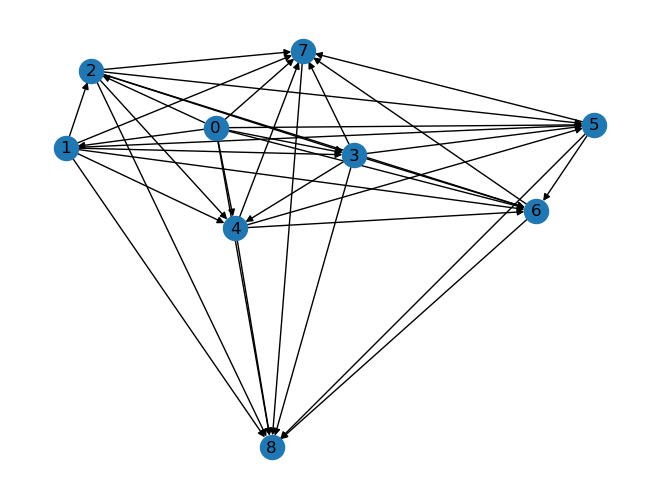

In [18]:
nx.draw(to_networkx(ec_graph_dataset[100]), with_labels=True)

In [16]:
edge_index_max = ec_graph_dataset[0].edge_index.max()
num_nodes = ec_graph_dataset[0].num_nodes
assert edge_index_max < num_nodes, f'edge_index_max: {edge_index_max}, num_nodes: {num_nodes}'

AssertionError: edge_index_max: 8, num_nodes: 4

In [14]:
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# use best parameters from tuning
model = graphLambda(learning_rate=0.0007403891589042272, optimizer_name='Adam', fc_layers=8, dropout=0.36385118123658544)
batch_size = 80
# Define the data loaders
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True


checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                      mode='max',
                                      save_top_k=5,
                                      filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                      )


trainer = Trainer(callbacks=[checkpoint_callback, RichProgressBar()],
                  accelerator='cpu',
                  max_epochs=100,
                  enable_progress_bar=True,
                  check_val_every_n_epoch=10,
                  log_every_n_steps=10,
                  )

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


┏━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name     ┃ Type                  ┃ Params ┃
┡━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ conv1    │ GCNConv               │  1.5 K │
│ 1  │ bn01     │ BatchNorm1d           │    512 │
│ 2  │ conv2    │ GCNConv               │ 32.9 K │
│ 3  │ bn02     │ BatchNorm1d           │    256 │
│ 4  │ conv3    │ GCNConv               │ 16.5 K │
│ 5  │ bn03     │ BatchNorm1d           │    256 │
│ 6  │ gat1     │ GATConv               │  6.1 K │
│ 7  │ bn11     │ BatchNorm1d           │  1.5 K │
│ 8  │ gat2     │ GATConv               │  296 K │
│ 9  │ bn12     │ BatchNorm1d           │    768 │
│ 10 │ gat3     │ GATConv               │  148 K │
│ 11 │ bn13     │ BatchNorm1d           │    768 │
│ 12 │ gin1     │ GINConv               │ 67.3 K │
│ 13 │ bn21     │ BatchNorm1d           │    512 │
│ 14 │ gin2     │ GINConv               │ 49.4 K │
│ 15 │ bn22     │ BatchNorm1d           │    256 │
│ 16 │ gin3     │ GINConv               │ 12.4 K │
│ 17 │ bn23     │ BatchNorm1d           │    128 │
│ 18 │ fcs      │ ModuleList            │  878 K │
│ 19 │ dropouts │ ModuleList            │      0 │
│ 20 │ train_f1 │ MulticlassF1Score     │      0 │
│ 21 │ val_f1   │ MulticlassF1Score     │      0 │
│ 22 │ val_cm   │ BinaryConfusionMatrix │      0 │
└────┴──────────┴───────────────────────┴────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 6

Output()

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

RuntimeError: index 2160 is out of bounds for dimension 0 with size 2160

In [92]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [40, 80, 120, 160, 200, 240])
    fc_layers = trial.suggest_int('fc_layers', 1, 8)
    dropout = trial.suggest_float('dropout', 0.2, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, fc_layers=fc_layers, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')


    # Create the model
    model = graphLambda(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=100,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=3)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('results_all_trials.pkl')

[I 2024-05-17 12:12:33,436] A new study created in memory with name: no-name-7870952b-3e28-4d4a-99c2-bf07d542c4c7


Tested parameters: {'learning_rate': 0.035845602974878724, 'optimizer_name': 'Adam', 'batch_size': 40, 'fc_layers': 4, 'dropout': 0.779782140727221}


[W 2024-05-17 12:12:35,978] Trial 0 failed with parameters: {'learning_rate': 0.035845602974878724, 'optimizer': 'Adam', 'batch_size': 40, 'fc_layers': 4, 'dropout': 0.779782140727221} because of the following error: RuntimeError('CUDA error: device-side assert triggered\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n').
Traceback (most recent call last):
  File "c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\call.py", line 44, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\trainer.py", line 580, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightnin

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [12]:
df_trials = pd.read_pickle('results_all_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_fc_layers,params_learning_rate,params_optimizer,state
128,128,0.786201,2024-05-06 18:53:37.963660,2024-05-06 18:57:11.774245,0 days 00:03:33.810585,120,0.486929,3,0.000161,RMSprop,COMPLETE
131,131,0.776247,2024-05-06 19:04:23.794962,2024-05-06 19:07:57.546190,0 days 00:03:33.751228,120,0.396842,3,0.000245,RMSprop,COMPLETE
176,176,0.768867,2024-05-06 21:06:52.152656,2024-05-06 21:14:01.104351,0 days 00:07:08.951695,40,0.276807,3,0.000314,RMSprop,COMPLETE
163,163,0.767183,2024-05-06 20:39:44.885513,2024-05-06 20:43:18.301455,0 days 00:03:33.415942,120,0.361064,3,0.000303,RMSprop,COMPLETE
130,130,0.760068,2024-05-06 19:00:48.963938,2024-05-06 19:04:23.791637,0 days 00:03:34.827699,120,0.446629,3,0.000229,RMSprop,COMPLETE
61,61,0.749530,2024-05-06 15:26:30.429036,2024-05-06 15:29:40.092183,0 days 00:03:09.663147,160,0.543649,4,0.000070,Adam,COMPLETE
42,42,0.746655,2024-05-06 14:45:25.923036,2024-05-06 14:48:01.128659,0 days 00:02:35.205623,240,0.564240,4,0.000133,Adam,COMPLETE
81,81,0.743330,2024-05-06 16:11:45.346080,2024-05-06 16:15:12.963716,0 days 00:03:27.617636,120,0.495136,1,0.000062,RMSprop,COMPLETE
199,199,0.743308,2024-05-06 22:49:22.838779,2024-05-06 22:52:00.439753,0 days 00:02:37.600974,240,0.573476,3,0.000083,RMSprop,COMPLETE
112,112,0.743262,2024-05-06 18:01:43.943028,2024-05-06 18:05:17.737147,0 days 00:03:33.794119,120,0.449105,2,0.000117,RMSprop,COMPLETE


### Visualizations

In [13]:
# function to change axes size
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

/tmp/ipykernel_4453/1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

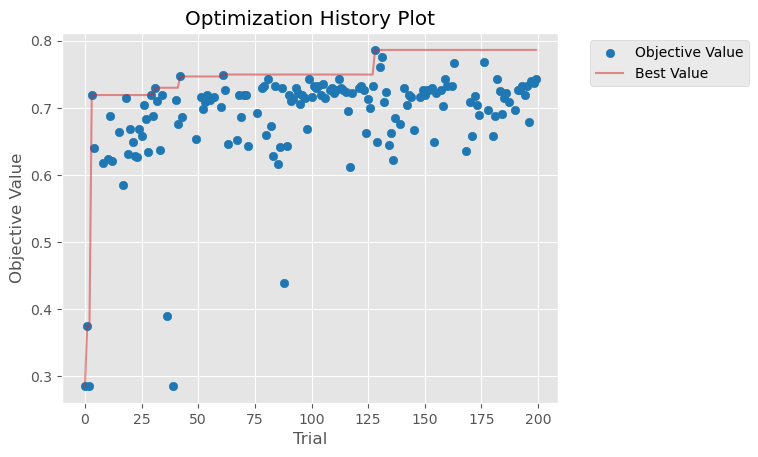

In [14]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-05-06 22:52:01,045] A new study created in memory with name: no-name-6e684638-fb4a-4f82-b58d-89431f02ffe8
/tmp/ipykernel_4453/1240065685.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


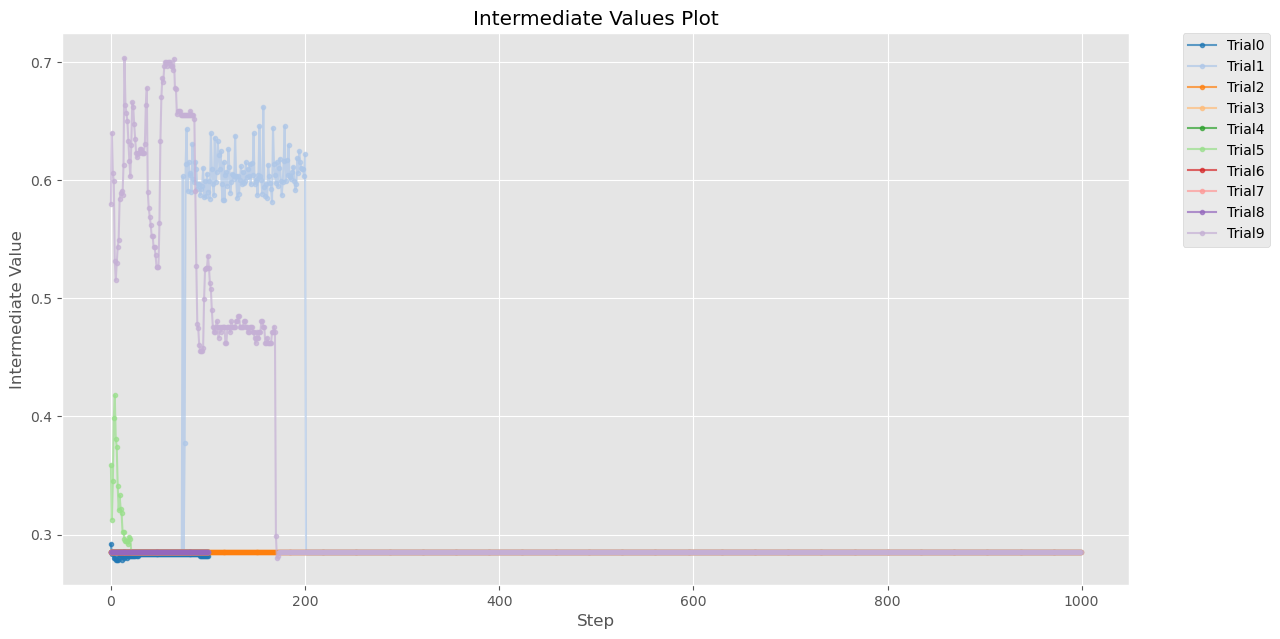

In [15]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

/tmp/ipykernel_4453/2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


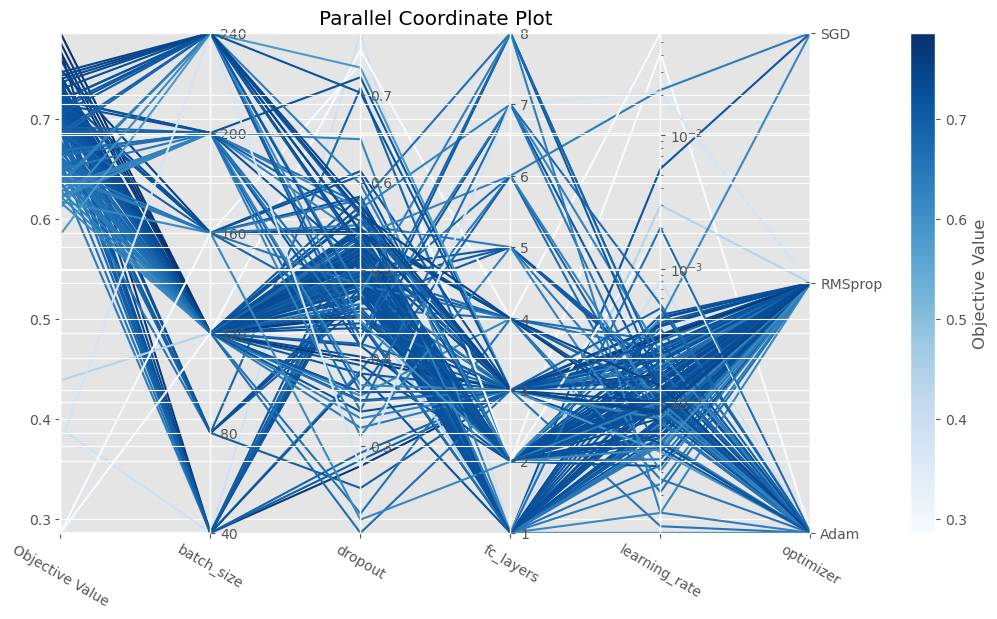

In [16]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

/tmp/ipykernel_4453/624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-05-06 22:52:02,169] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


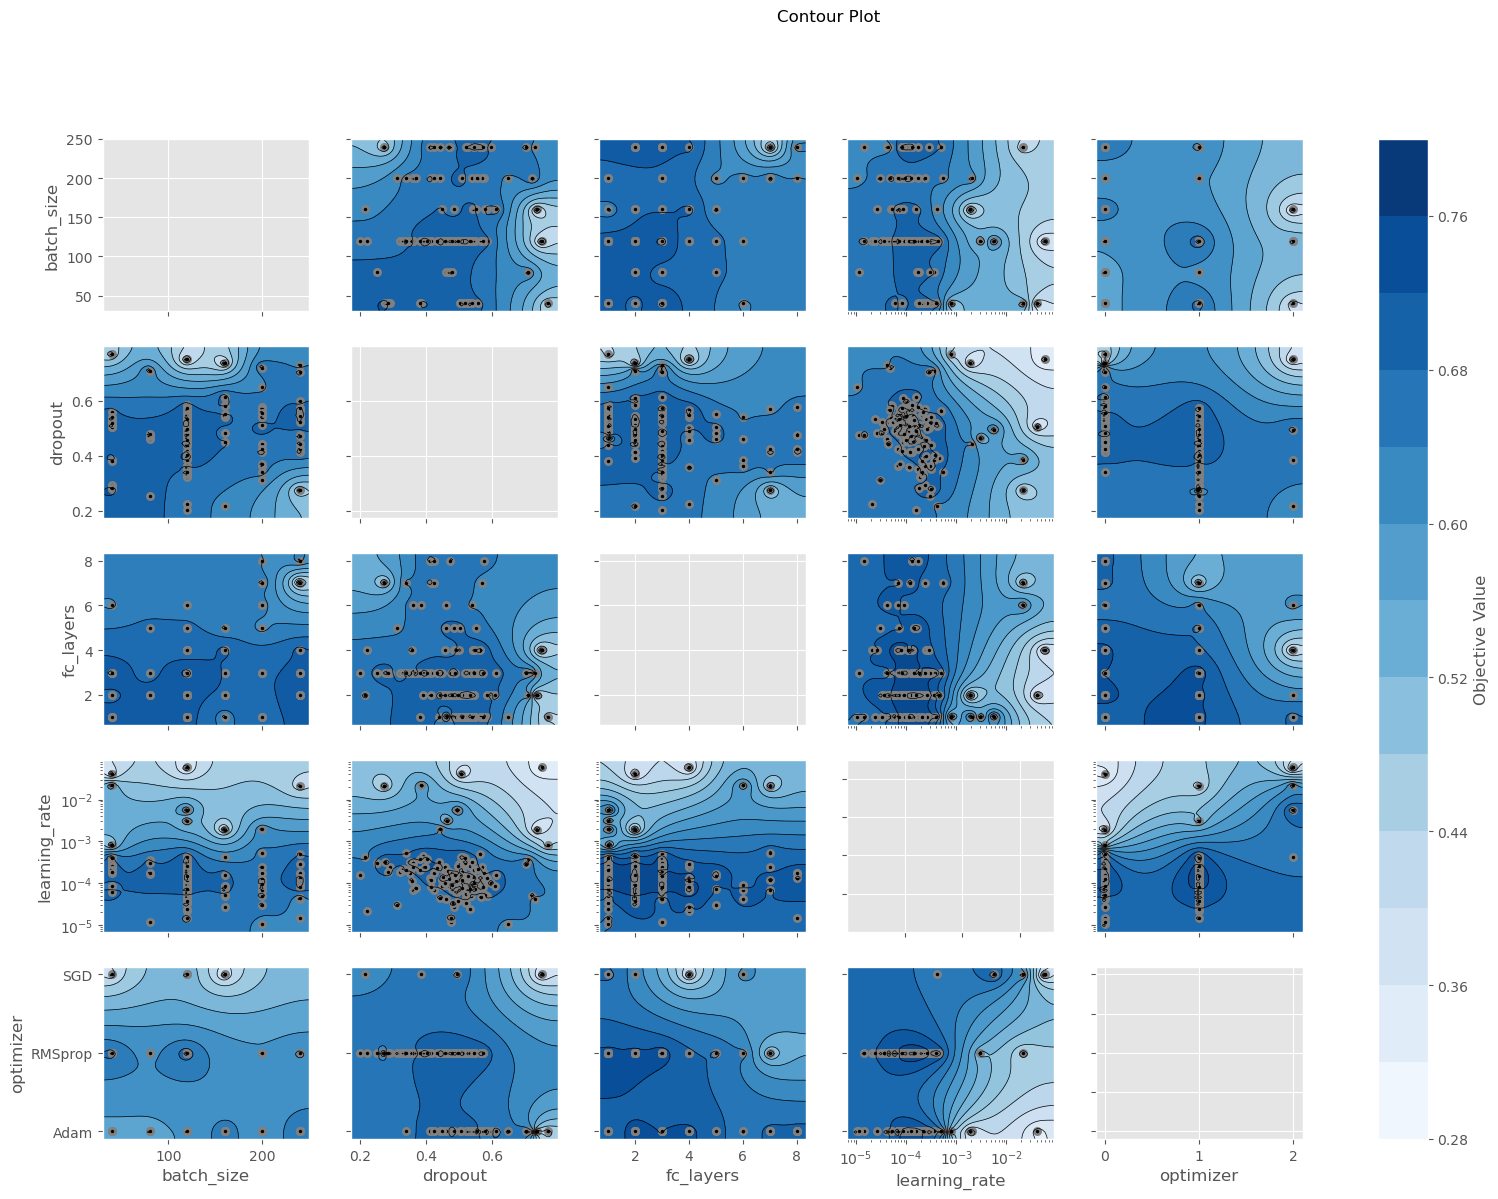

In [17]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

/tmp/ipykernel_4453/1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='fc_layers'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='optimizer'>],
      dtype=object)

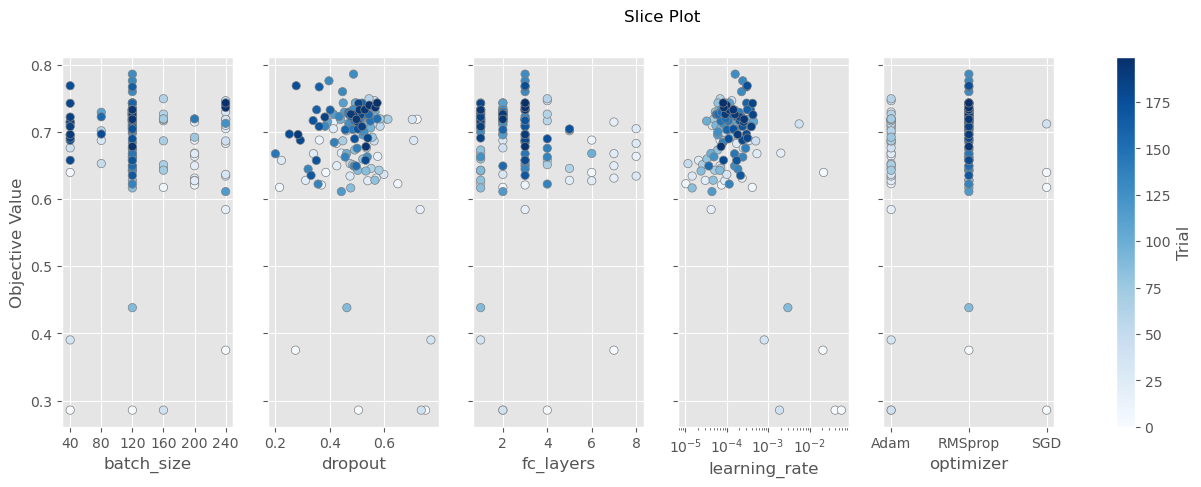

In [18]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

/tmp/ipykernel_4453/1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

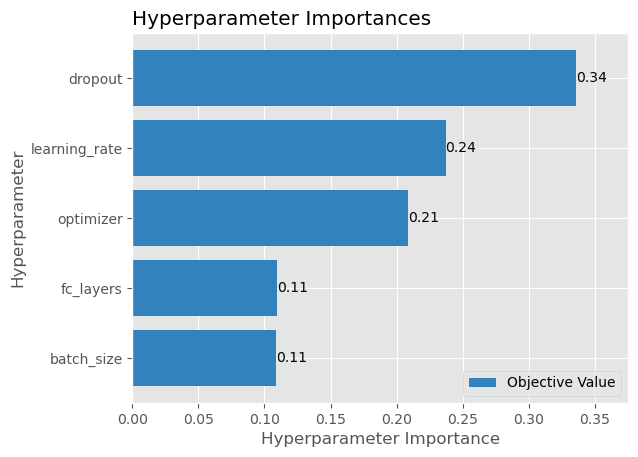

In [19]:
# Visualize parameter importances.
plot_param_importances(study)

/tmp/ipykernel_4453/3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

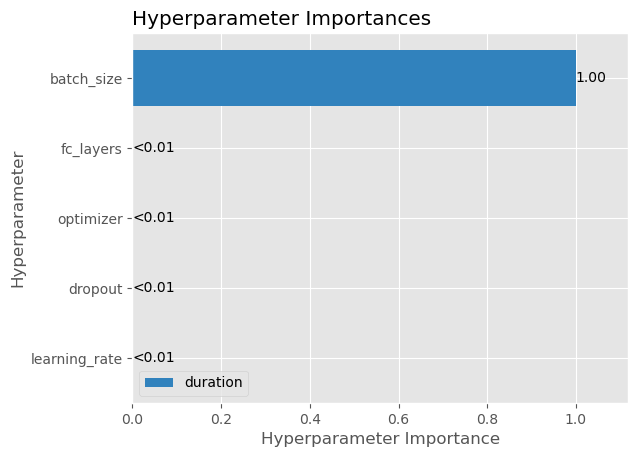

In [20]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

/tmp/ipykernel_4453/1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

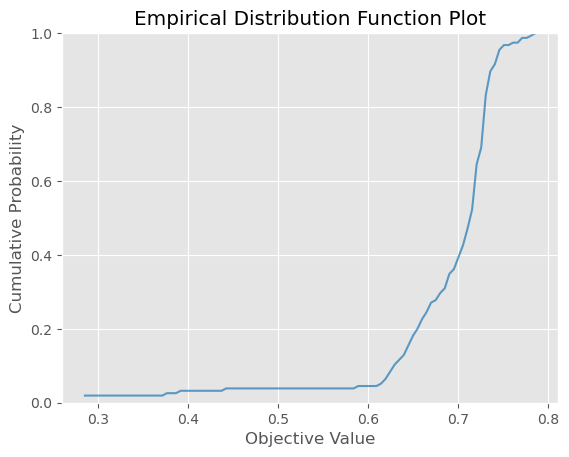

In [21]:
# Visualize empirical distribution function.
plot_edf(study)

/tmp/ipykernel_4453/1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-05-06 22:52:12,462] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


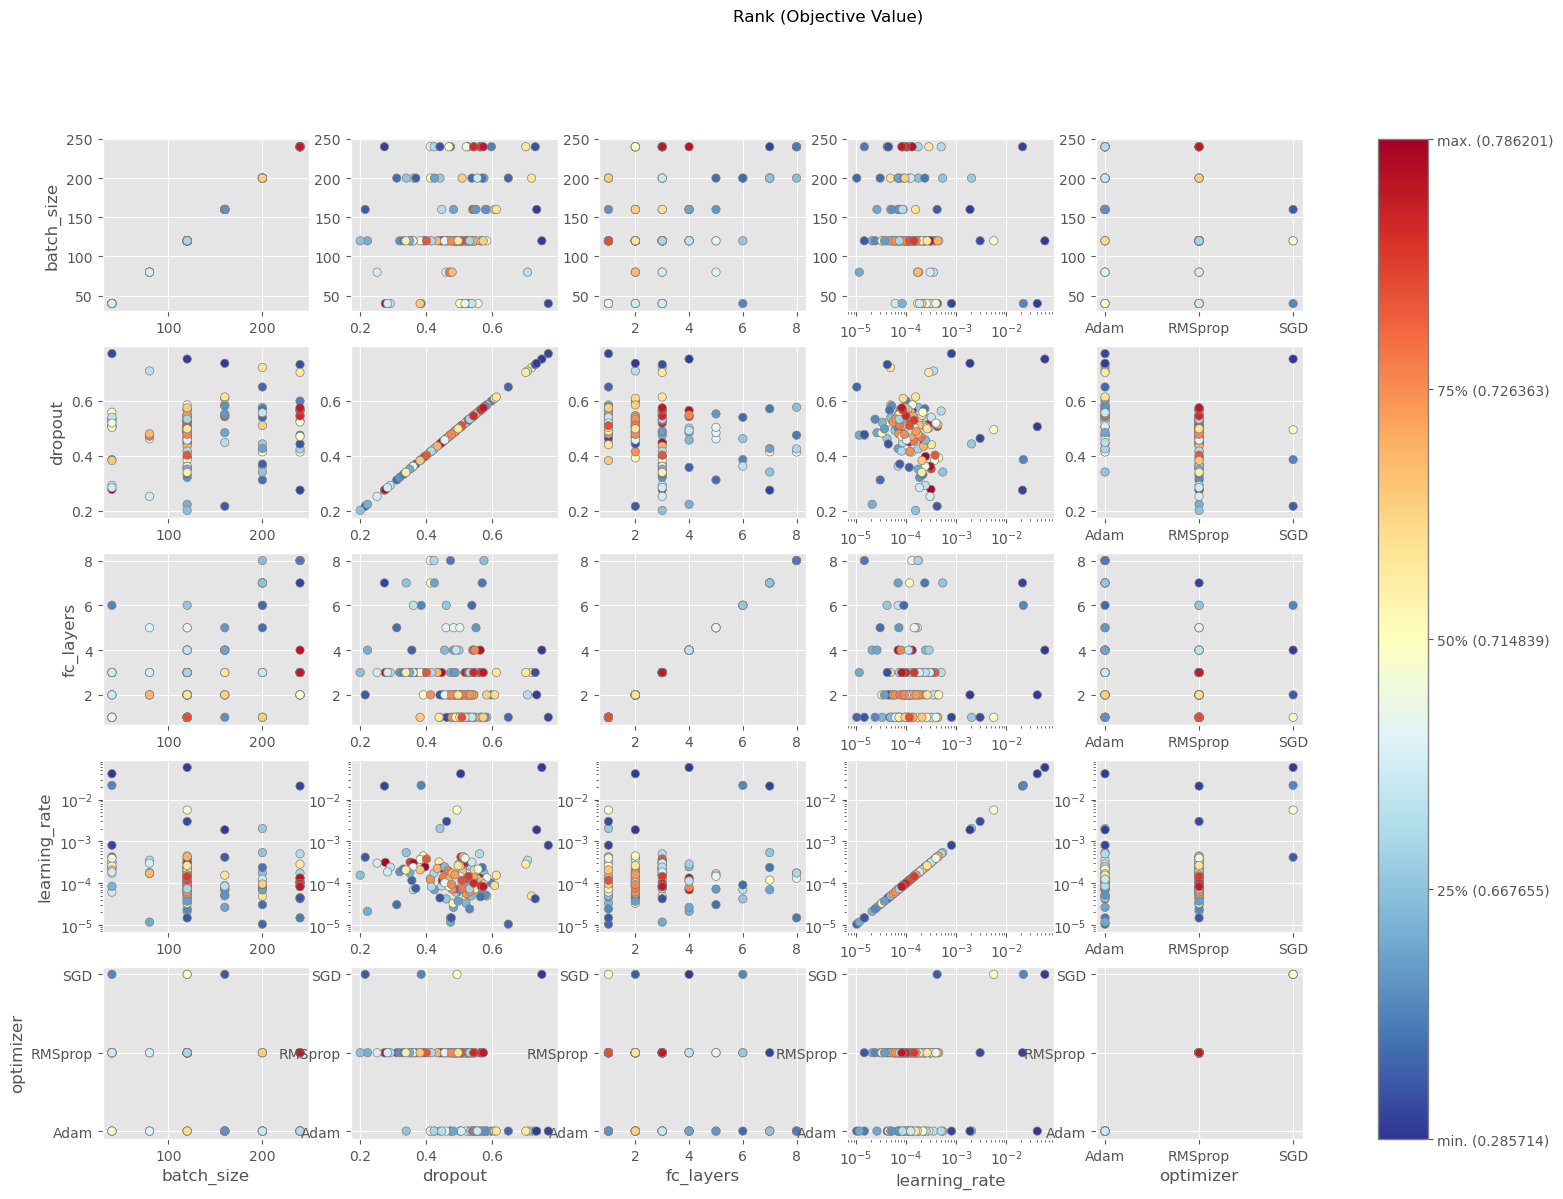

In [22]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

/tmp/ipykernel_4453/124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


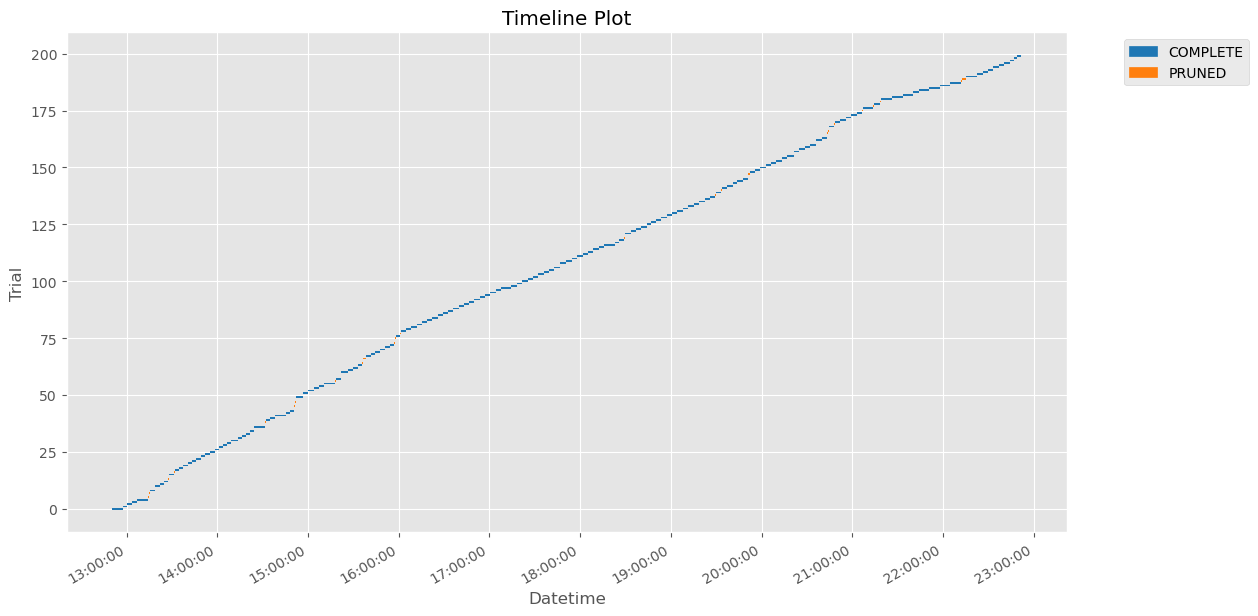

In [23]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

### Final eval

In [24]:
# from lightning.pytorch.tuner import Tuner
# from lightning.pytorch import Trainer
# from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
# from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# model = graphLambda(learning_rate=0.0014869034698895861, optimizer_name='Adam', fc_layers=6, dropout=0.2703865277626721)
# batch_size = 200
# # Define the data loaders
# train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
#                               drop_last=True) # , num_workers=0, persistent_workers=True
# val_loader = DataLoader(X_val, batch_size=batch_size, shuffle=False,
#                             drop_last=True) # , num_workers=0, persistent_workers=True


# checkpoint_callback = ModelCheckpoint(monitor='val_f1',
#                                       mode='max',
#                                       save_top_k=5,
#                                       filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
#                                       )


# trainer = Trainer(callbacks=[checkpoint_callback, RichProgressBar()],
#                   accelerator='gpu',
#                   max_epochs=100,
#                   enable_progress_bar=True,
#                   check_val_every_n_epoch=10,
#                   log_every_n_steps=10,
#                   )

# trainer.fit(model, train_loader, val_loader)

In [25]:
# trainer.validate(model, val_loader, ckpt_path='best')

In [26]:
# from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# y_pred = trainer.predict(model, val_loader, ckpt_path=r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Connectivity_project\EEG-Connectivity\models\lightning_logs\version_15\checkpoints\epoch=19-train_loss=0.55-train_f1=0.65-val_loss=0.39-val_f1=0.90.ckpt')
# y_pred = torch.cat((y_pred[0], y_pred[1]))
# y = Y_val

# class_labels = ['Control', 'ADHD']
# print('f1_score:', f1_score(y, y_pred, average='macro'))
# print()
# print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))

# # plot confusion matrix
# conf_matrix = confusion_matrix(y, y_pred)
# ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
